In [10]:
file = r"D:\論文實驗\result\distribution_10.txt"

revenue_list = []
expected_revenue_list = []
active_node_list = []
expected_active_node_list = []

with open(file, "r") as f:
    for line in f:
        if line == "\n":
            continue
        timestamp, runtime, revenue, expected_revenue, active_node, expected_active_node, times = line.split(",")
        revenue_list.append((float)(revenue.split("=")[1]))
        expected_revenue_list.append((float)(expected_revenue.split("=")[1]))
        active_node_list.append((float)(active_node.split("=")[1]))
        expected_active_node_list.append((float)(expected_active_node.split("=")[1]))


Avg. 757.0392200000005
Std. 427647.6506793902


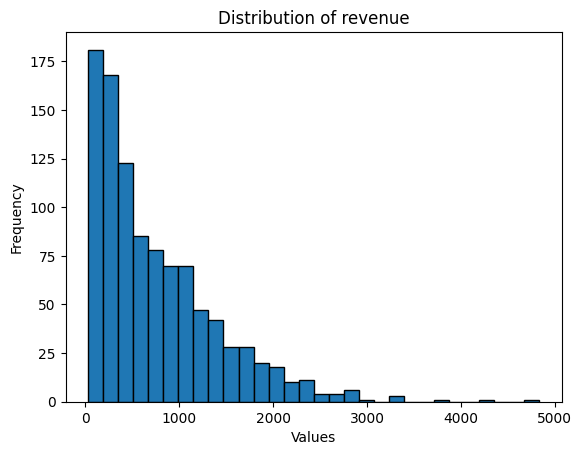

Avg. 38.2011112883425
Std. 50.02477569623976


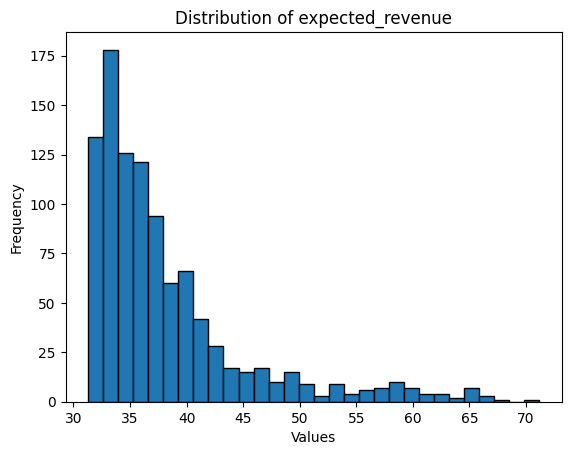

Avg. 46.808
Std. 1453.7071359999995


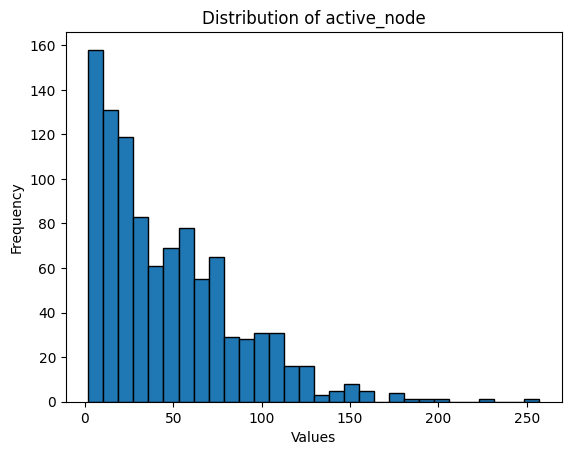

Avg. 2.33391980633366
Std. 0.05996797619833608


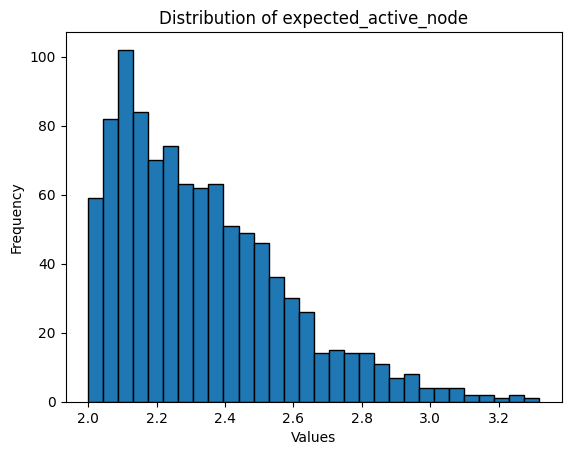

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def show(data:list, title:str):
    # 使用numpy.histogram自动计算級距
    hist, edges = np.histogram(data, bins=20)
    
    # 计算級距
    # bin_width = 0.1
    # bins = np.arange(min(data) - bin_width/2, max(data) + bin_width*1.5, bin_width)
    # print(bins)
    bins = 30

    # 使用Matplotlib创建直方图
    plt.hist(data, bins=bins, edgecolor='black', align='mid')

    # 添加标题和标签
    plt.title('Distribution of {0}'.format(title))
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    mean = sum(data)/len(data)
    print("Avg. {0}".format(mean))
    print("Std. {0}".format(sum([((x - mean) ** 2) for x in data]) / len(data) ))
    # 显示图形
    plt.show()

show(revenue_list, "revenue")
show(expected_revenue_list, "expected_revenue")
show(active_node_list, "active_node")
show(expected_active_node_list, "expected_active_node")